# Hubble Ultra Deep Field (f105w)

### reusing the sep workflow on the udf f105w image and then grabbing basic flux stats and a 3 color image using all of them towards the end

In [271]:
import numpy as np
import sep
import math
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse


sep.set_extract_pixstack(1000000)   
sep.set_sub_object_limit(100000)    

%matplotlib inline
rcParams["figure.figsize"] = [10., 8.]



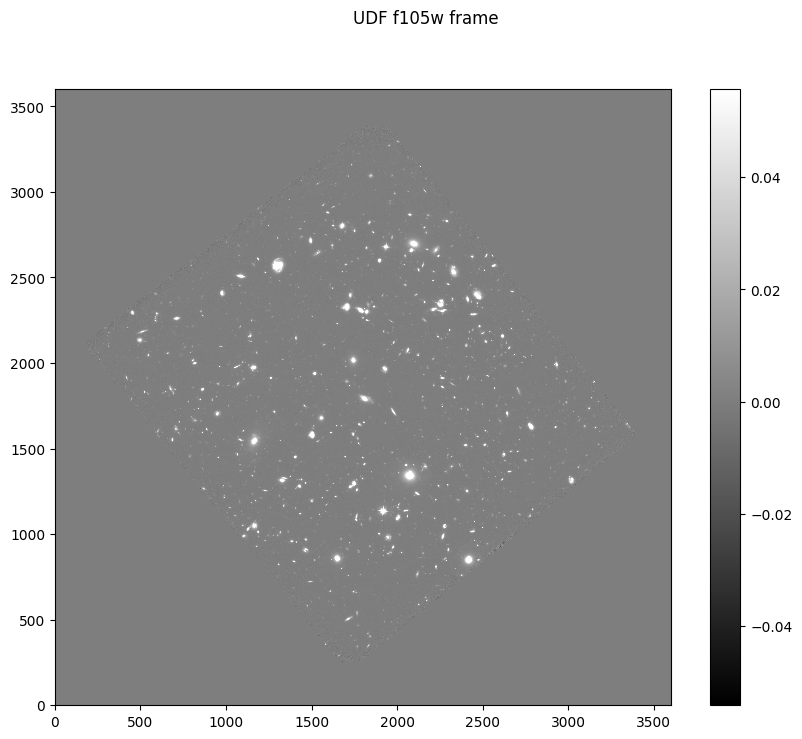

In [272]:
path = path = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"

img = fits.getdata(path)
img = img.astype(img.dtype.newbyteorder('='))

mid, spread = np.mean(img), np.std(img)

fig, ax = plt.subplots()
show = ax.imshow(
    img,
    interpolation = "nearest",
    cmap = "gray",
    vmin = mid - spread,
    vmax = mid + spread,
    origin = "lower",
)

fig.colorbar(show,ax=ax)
fig.suptitle("UDF f105w frame")
fig.savefig("../figs/udf105_img.png", dpi=150, bbox_inches="tight")
plt.show()


In [273]:
backg = sep.Background(img)
img_sub = img - backg

print("f105w backg level:", backg.globalback)
print("f105w backg rms:", backg.globalrms)

f105w backg level: 0.0
f105w backg rms: 0.0005398219218477607


In [274]:
sources105 = sep.extract(img_sub, 10.0, err=backg.globalrms)
len(sources105)

1544

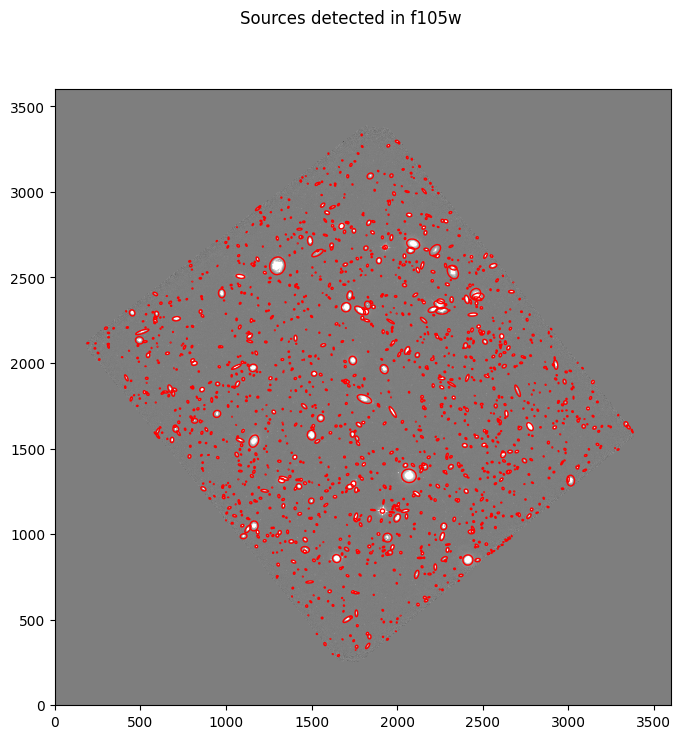

In [275]:
fig, ax = plt.subplots()
midimg_sub, spreadimgsub = np.mean(img_sub), np.std(img_sub)

show = ax.imshow(
    img_sub,
    interpolation = "nearest",
    cmap = "gray",
    vmin = midimg_sub - spreadimgsub,
    vmax = midimg_sub + spreadimgsub,
    origin = "lower",
)

for i in range(len(sources105)):
    e = Ellipse(
        xy=(sources105["x"][i], sources105["y"][i]),
        width=6 * sources105["a"][i],
        height=6 * sources105["b"][i],
        angle=sources105["theta"][i] * 180.0 / math.pi,
    )
    e.set_facecolor("none")
    e.set_edgecolor("red")
    ax.add_artist(e)

fig.suptitle("Sources detected in f105w")
fig.savefig("../figs/udf105_sources.png", dpi=150, bbox_inches="tight")
plt.show()

In [276]:

# looks like way too much???

# this frame appears to be EXTREMELY crowded, so SEP is detecting a large number of sources. additionally, i opted to increase the threshold to 10.0 sigma as it is appearing to properly isolate the right things. any lower, and it yields for too long and seems to pickup the wrong things. i'm not entirely sure if this was the right call, but it seems more appropriate to me. 

In [277]:
fluximg, fluxerr_img, img_flag = sep.sum_circle(
    img_sub,
    sources105["x"],
    sources105["y"],
    3.0,                 
    err=backg.globalrms, 
    gain=1.0
)


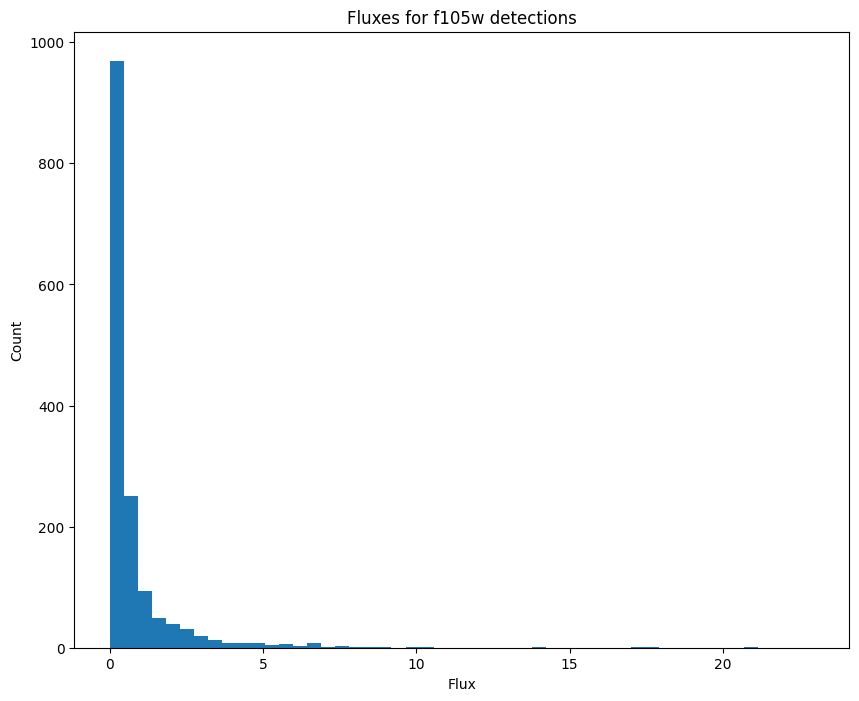

In [278]:
fig, ax = plt.subplots()

ax.hist(
    fluximg,
    bins=50,
    range = (0, np.percentile(fluximg, 99))
)

ax.set_xlabel("Flux")
ax.set_ylabel("Count")
ax.set_title("Fluxes for f105w detections")
fig.savefig("../figs/udf105_fux_hist.png", dpi=150, bbox_inches="tight")
plt.show()

# This shows the distribution of the aperture fluexes for all the sources SEP found. I trimmed it to just the top 1% so it's easier to see, if I make it much more inclusive it starts to lose its distinction.

In [279]:
flux_mean = np.mean(fluximg)
flux_med = np.median(fluximg)
flux_std = np.std(fluximg)

flux_mean, flux_med, flux_std

(np.float64(1.8989723625388009),
 np.float64(0.31331037910189485),
 np.float64(21.76880744251728))

In [280]:
bright_idx = np.argmax(fluximg)
bright_flux = fluximg[bright_idx]
bright_x = sources105["x"][bright_idx]
bright_y = sources105["y"][bright_idx]

bright_sigma = (bright_flux - flux_mean) / flux_std #sigma67


# From the flux histogram, pretty much every source is very faint. The brightest source I found has a flux of about 8.1×10^2 counts and is located at approximately x≈1914,y≈1134. That is about 37 standard deviations above the mean, so it sits way out in the bright tail of the distribution and is a very strong outlier.

In [281]:
path105 = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits" #i am going to redefine the original img (105) here as i was having difficulties with my naming scheme
path125 = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits" 
path160 = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

img105 = fits.getdata(path105, ext=0)
img125 = fits.getdata(path125, ext=0)
img160 = fits.getdata(path160, ext=0)


img105 = img105.astype(img105.dtype.newbyteorder("="))
img125 = img125.astype(img125.dtype.newbyteorder("="))
img160 = img160.astype(img160.dtype.newbyteorder("="))

back105 = sep.Background(img105)
back125 = sep.Background(img125)
back160 = sep.Background(img160)


img160_sub = img160 - back160
img125_sub = img125 - back125
img105_sub = img105 - back105

print("160:", img160.min(), img160.max())
print("125:", img125.min(), img125.max())
print("105:", img105.min(), img105.max())



160: -0.009378761 56.835293
125: -0.010169286 70.19213
105: -0.9047293 74.44648


In [282]:
r = (img160_sub - img160_sub.min()) / (img160_sub.max() - img160_sub.min())
g = (img125_sub - img125_sub.min()) / (img125_sub.max() - img125_sub.min())
b = (img105_sub - img105_sub.min()) / (img105_sub.max() - img105_sub.min())

r *= 500
g *= 500
b *= .5

rgb = np.dstack([r, g, b])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..500.0].


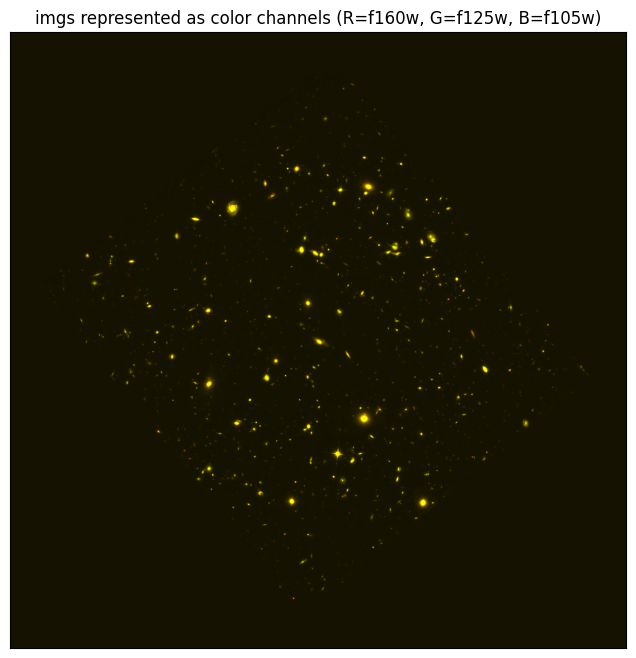

In [283]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb, origin="lower")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("imgs represented as color channels (R=f160w, G=f125w, B=f105w)")
fig.savefig("../figs/udf_rgb.png", dpi=200, bbox_inches="tight")
plt.show()


# When I worked on this last night, it was producing a blue image. I woke up and took another attempt, but I can not get the colors normalized properly. I was getting a pure black image, so I tried scaling the channels. Blue seems to dominate the entire image, which doesn't make any sense to me, but I have now bumped red and green, and am getting a somewhat proper image? I hope this suffices.